In [27]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import os
from PIL import Image

In [9]:
class FLOWERS17(Dataset):
    def __init__(self, root, transform=None, train=True):
        self.root = root + "/17flowers/"
        self.train = train
        self.transform = transform
        self.content = self.get_content()
        
    def get_content(self):
        dataset = []
        idx_file = "dataset.txt"
        if not os.path.exists(self.root + idx_file):
            with open(self.root + idx_file, "w", encoding="utf-8") as fw:
                dirs = os.listdir(self.root)
                for d in dirs:
                    if os.path.isdir(self.root + d):
                        for f in os.listdir(self.root + d):
                            if not os.path.isdir(self.root + d + "/" + f):
                                fw.write(self.root + d + "/" + f+ " " + d + "\n")
                                dataset.append([self.root + d + "/" + f, d])
        else:
            with open(self.root + idx_file, "r", encoding="utf-8") as fr:
                for line in fr.readlines():
                    dataset.append(line.strip().split(" "))
        return dataset
    
    def __getitem__(self, idx):
        path, label = self.content[idx]
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
        
    def __len__(self):
        return len(self.content)

In [16]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.c4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.c5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc6 = nn.Sequential(
            nn.Linear(in_features=7*7*512, out_features=4096),
            nn.ReLU(),
            nn.Dropout()
        )
        self.fc7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout()
        )
        self.fc8 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=17),
            nn.ReLU(),
            nn.Dropout()
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.normal_(m.weight, mean=0, std=0.01)
                init.constant(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                init.constant(m.bias, 0)
    
    def forward(self, x):
        x = self.c5(self.c4(self.c3(self.c2(self.c1(x)))))
        x = x.view(-1, 7*7*512)
        x = self.fc8(self.fc7(self.fc6(x)))
        
        return x

In [17]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

In [18]:
net = VGGNet()
get_parameter_number(net)

/Users/yank/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/Users/yank/opt/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


{'Total': 134330193, 'Trainable': 134330193}

In [19]:
BATCH_SIZE = 64
EPOCH = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

In [31]:
transform = transforms.Compose([
    transforms.RandomCrop(size=224, pad_if_needed=True),
    transforms.ToTensor()
])
data_train = datasets.ImageFolder("./data/17flowers/", transform=transform)
train_dataset = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
loss_data = []
for epoch in range(EPOCH):
    for i, data in enumerate(train_dataset):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss_data.append(loss)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(train_dataset.dataset), 100. * i / len(train_dataset), loss.item()))

Train Epoch: 0 [0/1360 (0%)]	Loss: 2.833243


KeyboardInterrupt: 

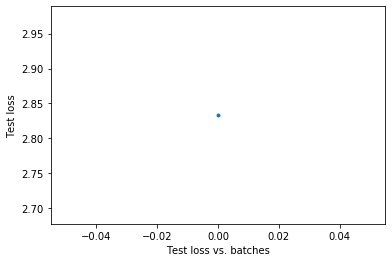

In [33]:
plt.plot(range(0, len(loss_data)), loss_data, '.-')
plt.xlabel('Test loss vs. batches')
plt.ylabel('Test loss')
plt.show()